# Projet Épidémiologie - MDI230

#### 28/06/2022

Rémy TANG, Liwei YAO, Darius MUNGUR

## Contexte

Il s'agit de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie.

## Paramètres

In [1]:
# Librairies utilisées
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', context='notebook', palette='deep')

In [2]:
# Paramètres des modèles

# Pour les modèles épidémiologiques
beta = 2
gamma = 1
R0 = beta /gamma

# N = 67287241 # Population française au 1er janvier 2020
N = 10000

t = [0,1000]

# Population initiale (effectif total : N+1)
s0 = N # Population susceptible, initialement toute la population
i0 = 1 # Population infectée, initialement une personne
r0 = 0 # Population retirée parce que décédée ou immunisée

# Conditions initiales
y0 = [s0, i0, r0]

## Modèle déterministe SIR

On reprend le modèle déterministe SIR du cours avec les paramètres définis au dessus.

In [3]:
# Modèle SIR 
def SIR(t, y, beta, gamma, N):
    S, I, R = y
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

Puis on résout le système d'équations différentielles ordinaires pour obtenir la courbe d'évolution de l'épidémie sur une durée donnée (en jours).

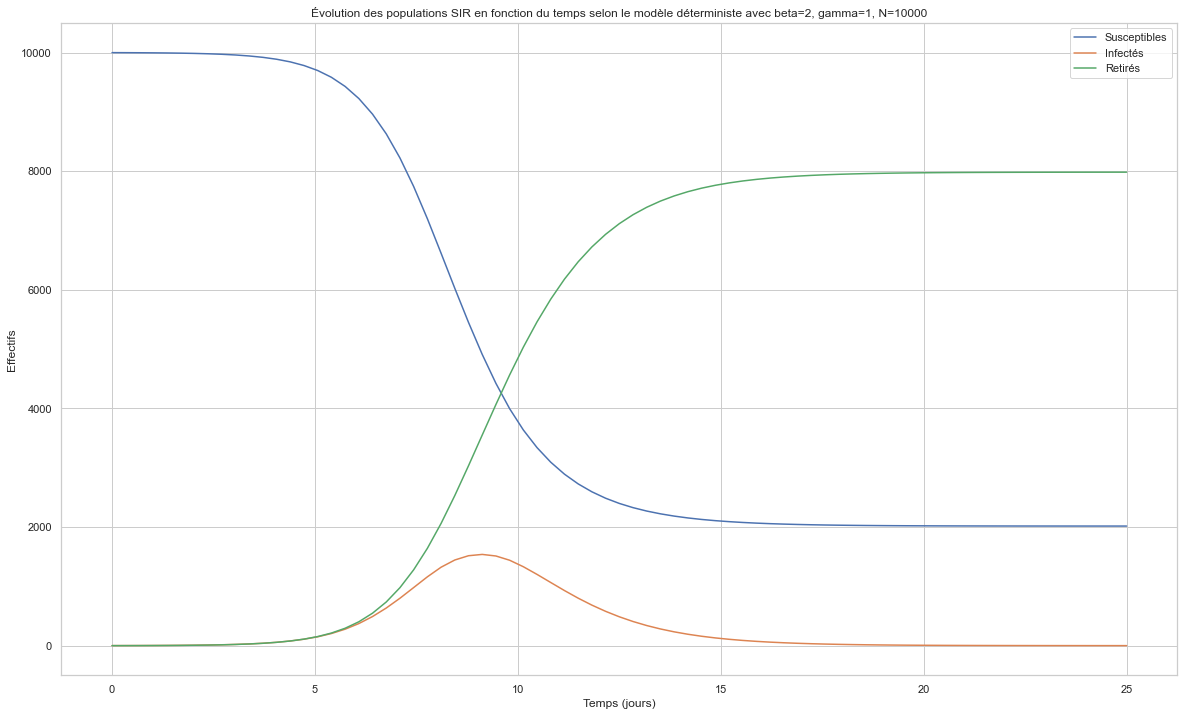

In [4]:
# Plot de la courbe de SIR
tf = 25 # Nombres de jours à simuler
y = solve_ivp(SIR, t, y0, args=(beta, gamma, N), t_eval=np.linspace(0, tf, tf * 3))

plt.figure(figsize=(20,12))
sns.lineplot(x=y.t, y=y.y[0], label='Susceptibles')
sns.lineplot(x=y.t, y=y.y[1], label='Infectés')
sns.lineplot(x=y.t, y=y.y[2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle déterministe avec beta={beta}, gamma={gamma}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.legend()
plt.show()

## Modèle Markovien

On reprend le code effectué pour le projet Vélib en l'adaptant à la situation épidémiologique. Cette fois on n'effectue que 2 tirages, un pour obtenir le temps avant la prochaine infection, et l'autre pour obtenir le temps avant la prochaine guérison ou le prochain décès.

In [5]:
def simulation_processus_markov_SIR(etat_init, n_jours, N , beta, gamma):
    """
    Simulation des trajectoires du processus de Markov,
    avec des intervalles entre infections ou sortie de l'état infecté
    suivant des lois exponentielles

    Paramètres
    ----------
    :etat_init: État initial de la population
    :n_jours: Nombre de jours à simuler
    :N: Population totale
    :beta: Taux d'infection
    :gamma: Taux de guérison
    """
    # Initialisation
    t = [0]                             # Axe du temps en jours, à chaque valeur correspond à un changement d'état
    trajectoire = [etat_init.copy()]    # Liste des états
    
    while (t[-1] < n_jours):
        
        # Taux de transition pour les nouvelles infections
        if trajectoire[-1][0] > 0 and trajectoire[-1][1] > 0:
            # taux_transition_infection = beta * trajectoire[-1][1] * max(trajectoire[-1][0], 0)/ N
            taux_transition_infection = beta * trajectoire[-1][1] * trajectoire[-1][0]/ N
            # Temps avant une nouvelle infection
            temps_transition_infection = np.random.exponential(1/taux_transition_infection)
        else:
            temps_transition_infection = np.inf

        # Taux de transition pour les décès et les guérisons
        if trajectoire[-1][1] > 0:
            # taux_transition_retire = gamma * max(trajectoire[-1][1], 0)
            taux_transition_retire = gamma * trajectoire[-1][1]
            # Temps avant un nouveau décès ou une noubelle guérison
            temps_transition_retire = np.random.exponential(1/taux_transition_retire)
        else:
            temps_transition_retire = np.inf

        # Calcul de la prochaine transition
        nouvel_etat = trajectoire[-1].copy()

        # On garde le temps minimum à partir des tirages pour obtenir la prochaine transition
        # Comme le processus est sans mémoire, on refait un tirage après cette transition
        if temps_transition_infection < temps_transition_retire and temps_transition_infection > 0:
            t.append(t[-1] + temps_transition_infection)
            nouvel_etat[1] += 1
            nouvel_etat[0] -= 1
        elif temps_transition_retire < temps_transition_infection and temps_transition_retire > 0:
            t.append(t[-1] + temps_transition_retire)
            nouvel_etat[2] += 1
            nouvel_etat[1] -= 1
        elif temps_transition_infection == np.Inf and temps_transition_retire == np.Inf:
            break

        trajectoire.append(nouvel_etat)

    return trajectoire,t


On peut à nouveau simuler la propagation du virus sur la même échelle de temps qu'avec le modèle déterministe. Un point important est qu'avec le modèle markovien probabiliste, il est possible que le virus échoue à se propager tout au début, auquel cas le ou les premiers infectés guérissent avant que l'épidémie ne survienne.

In [6]:
# Simulation sur un maximum de n_jours
n_jours = 100
trajectoire, temps = simulation_processus_markov_SIR(y0, n_jours, N, beta, gamma) # Relancer la simulation autant de fois que nécessaire en cas d'échec de propagation du virus

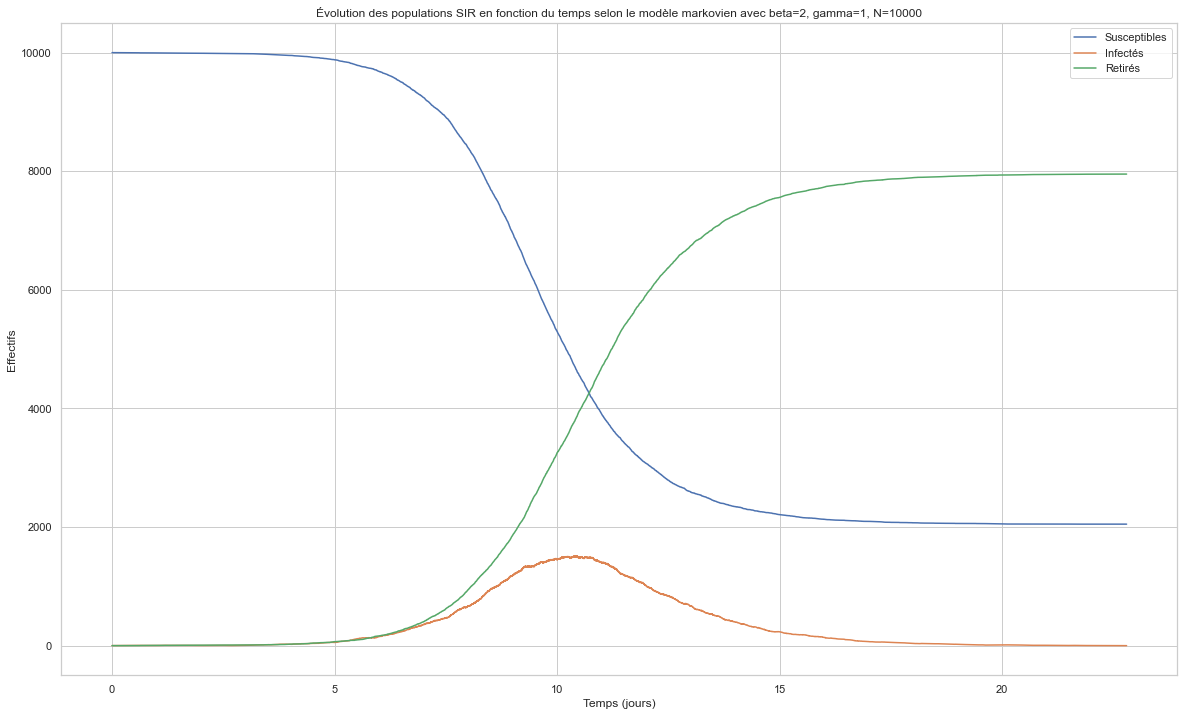

In [7]:
# Affichage de l'évolution de l'épidémie avec les trajectoires de Markov
traj = np.array(trajectoire)

plt.figure(figsize=(20,12))
sns.lineplot(x=temps, y=traj[:,0], label='Susceptibles')
sns.lineplot(x=temps, y=traj[:,1], label='Infectés')
sns.lineplot(x=temps, y=traj[:,2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle markovien avec beta={beta}, gamma={gamma}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.show()

On observe que la courbe obtenue avec le modèle markovien est remarquablement similaire à celle obtenue avec le modèle déterministe.

## Paramètres (beta, gamma) pour que tout le monde soit retiré sur le long terme

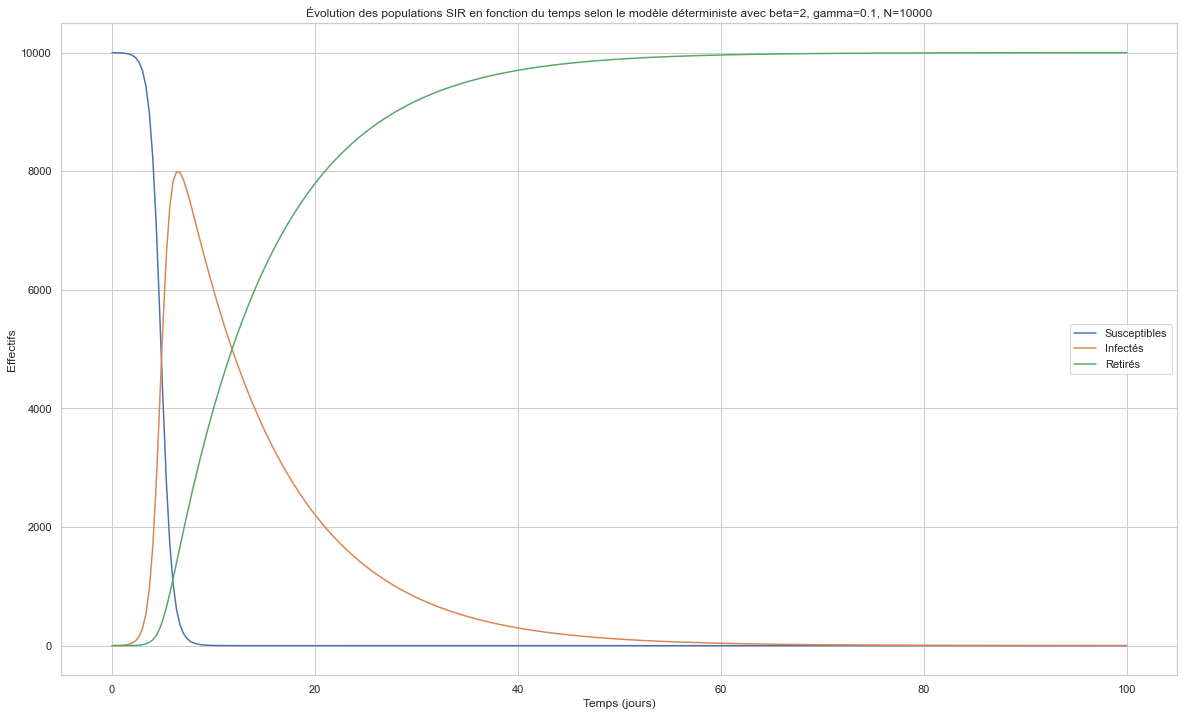

In [8]:
# Plot de la courbe de SIR
beta = 2
gamma = 0.1
tf = 100 # Nombres de jours à simuler
y = solve_ivp(SIR, t, y0, args=(beta, gamma, N), t_eval=np.linspace(0, tf, tf * 3))

plt.figure(figsize=(20,12))
sns.lineplot(x=y.t, y=y.y[0], label='Susceptibles')
sns.lineplot(x=y.t, y=y.y[1], label='Infectés')
sns.lineplot(x=y.t, y=y.y[2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle déterministe avec beta={beta}, gamma={gamma}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.legend()
plt.show()

## Paramètres (beta, gamma) pour qu'une partie de la population reste susceptible et l'autre soit retirée

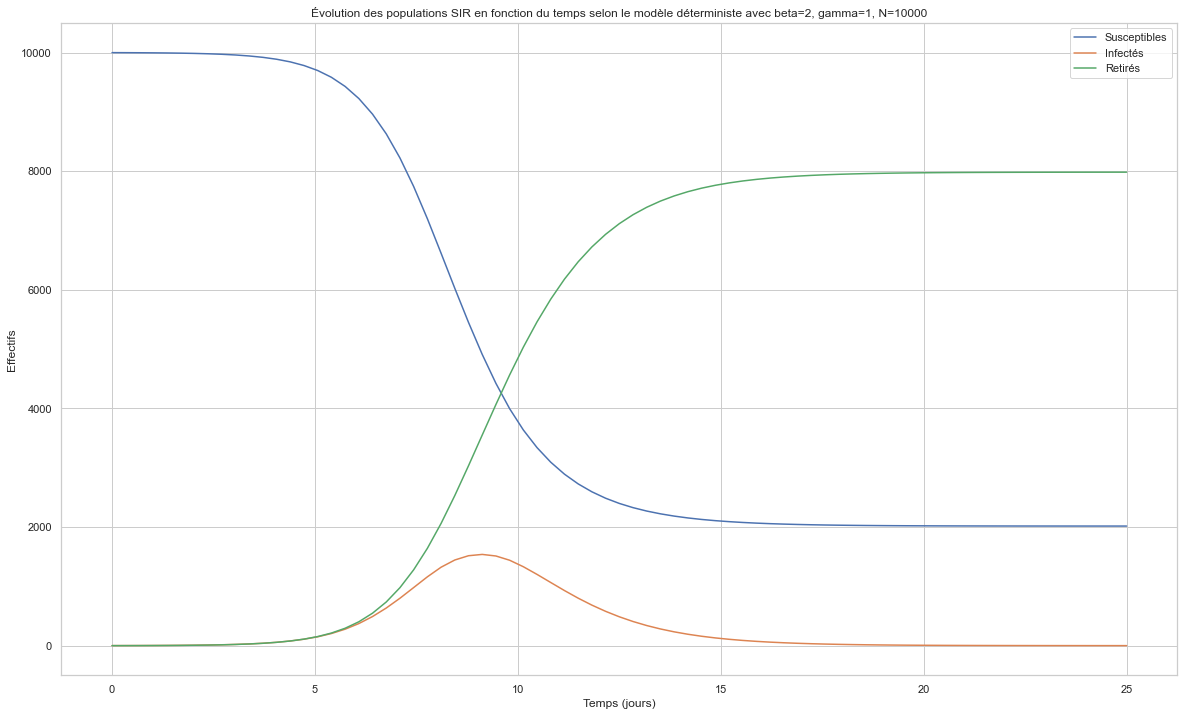

In [9]:
# Plot de la courbe de SIR
beta = 2
gamma = 1
tf = 25 # Nombres de jours à simuler
y = solve_ivp(SIR, t, y0, args=(beta, gamma, N), t_eval=np.linspace(0, tf, tf * 3))

plt.figure(figsize=(20,12))
sns.lineplot(x=y.t, y=y.y[0], label='Susceptibles')
sns.lineplot(x=y.t, y=y.y[1], label='Infectés')
sns.lineplot(x=y.t, y=y.y[2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle déterministe avec beta={beta}, gamma={gamma}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.legend()
plt.show()

## Illustration de la convergence du processus de Markov renormalisé vers la solution du système déterministe

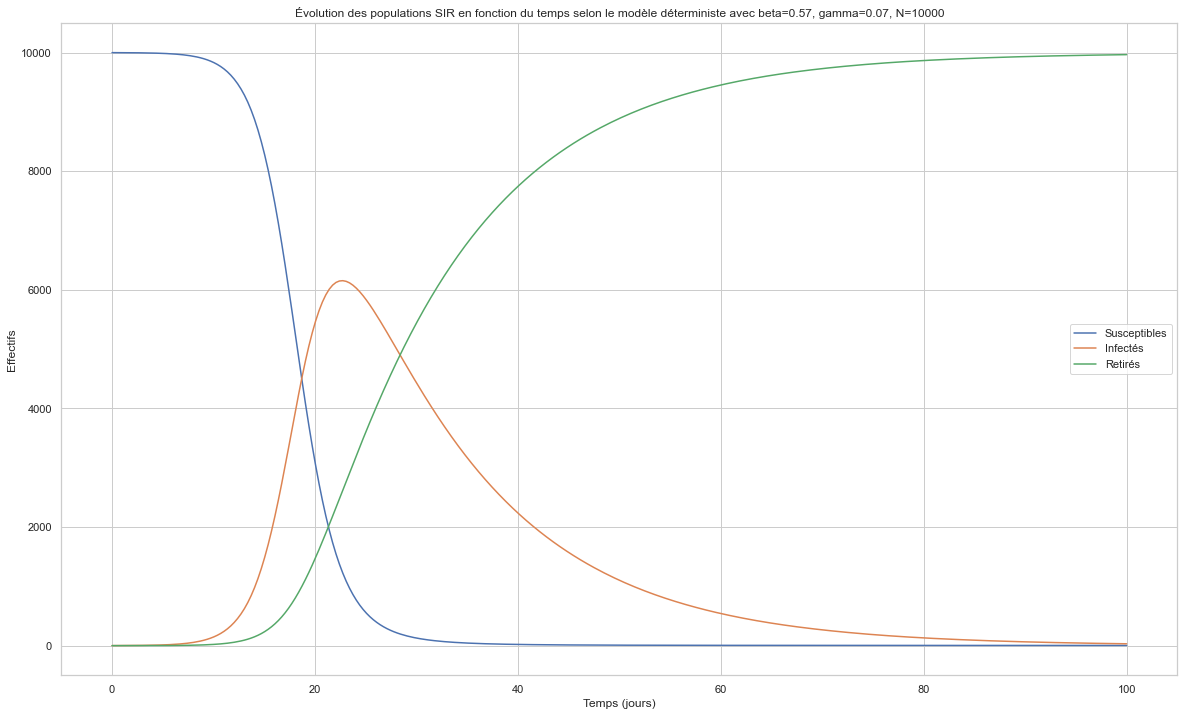

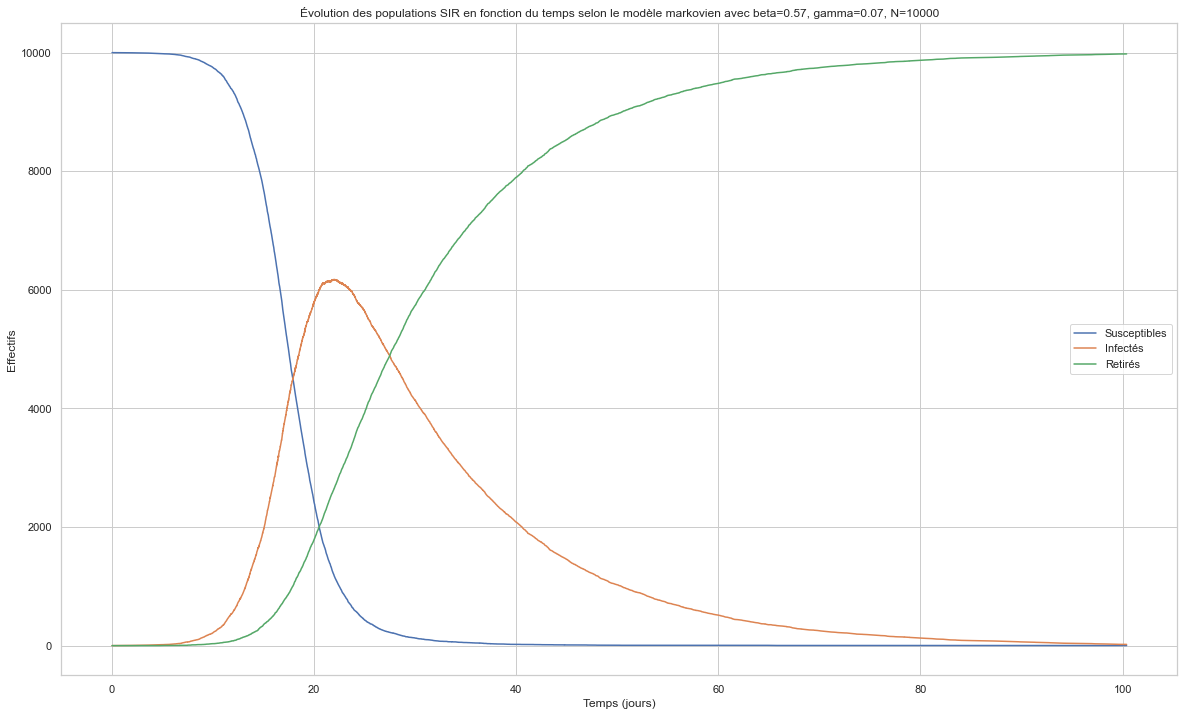

In [10]:
beta = 8/14
gamma = 1/14
N = 10000
n_jours = 100# Nombres de jours à simuler

# Modèle détérministe


y = solve_ivp(SIR, t, y0, args=(beta, gamma, N), t_eval=np.linspace(0, n_jours, n_jours * 3))

plt.figure(figsize=(20,12))
sns.lineplot(x=y.t, y=y.y[0], label='Susceptibles')
sns.lineplot(x=y.t, y=y.y[1], label='Infectés')
sns.lineplot(x=y.t, y=y.y[2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle déterministe avec beta={str(beta)[:4]}, gamma={str(gamma)[:4]}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.legend()
plt.show()

# Modèle Markovien

trajectoire, temps = simulation_processus_markov_SIR(y0, n_jours, N, beta, gamma) # Relancer la simulation autant de fois que nécessaire en cas d'échec de propagation du virus

traj = np.array(trajectoire)
plt.figure(figsize=(20,12))
sns.lineplot(x=temps, y=traj[:,0], label='Susceptibles')
sns.lineplot(x=temps, y=traj[:,1], label='Infectés')
sns.lineplot(x=temps, y=traj[:,2], label='Retirés')
plt.title(f'Évolution des populations SIR en fonction du temps selon le modèle markovien avec beta={str(beta)[:4]}, gamma={str(gamma)[:4]}, N={N}')
plt.xlabel('Temps (jours)')
plt.ylabel('Effectifs')
plt.show()